In [1]:

import os
from bs4 import BeautifulSoup
import re

## Data cleaning and Preprocessing

In [2]:
# Convert HTML documents to text

def convert_to_text(src_dir, target_dir):
    for file in os.listdir('../data/original_policies'):
        with open('../data/original_policies' + '/' + file, 'r', encoding="ISO-8859-1") as f:
            print(file)
            data = f.read()
            # print(data)
            bs = BeautifulSoup(data,'html.parser')
            texts = bs.findAll(['title', 'body','p','strong'])

        with open('../data/clean_policies' + '/' + file, 'w') as f:
            for t in texts:
                f.write(t.text)


In [3]:
# Remove tags from the documents
def convert_clean_summaries(src_dir, target_dir):
    for file in os.listdir('../data/sanitized_policies'):
        with open('../data/sanitized_policies' + '/' + file, 'r', encoding="ISO-8859-1") as f:

            cleanr = re.compile('<.*?>')
            cleantext = re.sub(cleanr, '', f.read())
            filename = file.split('.', -1)[0] + '.txt'

        with open('../data/notags_policies' + '/' + filename, 'w') as f:
            f.write(cleantext)


In [4]:
# remove all the punctuations from the text
def remove_punctuation(data):
    data = re.sub("_", "", data)
    data = re.sub("[^\w\s]", "", data)
    data = re.sub(' +', ' ', data)

    return data




In [6]:
import spacy
import os
import numpy as np
import scipy.spatial.distance as distance
import gensim
from collections import defaultdict
import re
from src.preprocess import remove_punctuation
from sklearn.neighbors import KNeighborsClassifier
import math


word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    "../data/GoogleNews-vectors-negative300.bin", binary=True)
nlp = spacy.load('en_core_web_sm')

In [ ]:
para2vec = gensim.models.KeyedVectors.load_doc2vec_format

In [160]:
CLASS_NUM = {'Data Retention' : 0,
 'Data Security' : 1,
 'Do Not Track' : 2,
 'First Party Collection/Use' : 3,
 'International and Specific Audiences' : 4,
 'Policy Change' : 5,
 'Third Party Sharing/Collection' : 6,
 'User Access, Edit and Deletion' : 7,
 'User Choice/Control' : 8,
 'Other' : 9}

## Word Weights

In [161]:
def word_weights(filepath):

    with open(filepath) as f:
        content = f.read()



## Create Vectors

In [216]:
def get_sentence_vector(sentence):
    print("Geting maximum sentence similarity of each sentence...")
    word2vec_dict = word2vec.vocab.keys()

    wordvecs = []
    # sentence = nlp(sentence)
    for word in sentence:
        # Words in a summary that are not covered by Word2Vec are discarded.
        word = str(word).lower()
        if word in word2vec_dict:
            wordvecs.append(word2vec[word])

    wordvecs = np.array(wordvecs)
    # represent each sentence as average of its word embedding
    sentence_score = np.mean(wordvecs, axis=0)


    return sentence_score



In [260]:
# TODO: Modify explanation


#  Paragraph2Vec technique includes several different algorithm. 
# The only difference from word2vec is inclusion of documents along with words as input nodes. 
# P2V neural net has input nodes representing documents in the training data (see fig 2).
# The rationale behind including documents as input nodes is based upon considering documents as another context. 
# In this abstract sense of context there is no difference between a word and a document. 
# At the time of training we consider (context set, target) pairs as in word2vec, however,
# for P2V document is also considered a member of the context set.
# The objective function and the training update steps are exactly the same as word2vec.

def get_paragraph_vector(paragraph):
#     print("Vectorizing Paragraph")
    word2vec_dict = word2vec.vocab.keys()
    sentences = nlp(paragraph)

    wordvecs = []
    # sentence = nlp(sentence)
    for word in sentences:
        # Words in a summary that are not covered by Word2Vec are discarded.
        word = str(word.text).lower()
        if word in word2vec_dict:
            wordvecs.append(word2vec[word])

    wordvecs = np.array(wordvecs)
    # represent each sentence as average of its word embedding
    paragraph_score = np.mean(wordvecs, axis=0)


    return paragraph_score



## Baseline Model

In [247]:
def calculate_sentence_sim(s1):
    #       - Statement 1 (Clear Purpose): For what purposes does the company use personal information?
    #     # - Statement 2 (Third Parties): Does the company share my information with third parties?
    #     # - Statement 3 (Limited Collection): Does the company combine my information with data from other sources?
    #     # - Statement 4 (Limited Use): Will the company sell, re-package or commercialize my data?
    #     # - Statement 5 (Retention): Will the company retain my data? What is their retention policy?

    s  = get_sentence_vector(s1)
    c1 = get_sentence_vector(nlp(remove_punctuation("For what purposes does the company use personal information?")))
    c2 = get_sentence_vector(nlp(remove_punctuation("Does the company share my information with third parties?")))
    c3 = get_sentence_vector(nlp(remove_punctuation("Does the company combine my information with data from other sources?")))
    c4 = get_sentence_vector(nlp(remove_punctuation("Will the company sell, re-package or commercialize my data?")))
    c5 = get_sentence_vector(nlp(remove_punctuation("Will the company retain my data? What is their retention policy?")))

    res = [0] * 5
    res[0] = 1 - distance.cosine(s, c1)
    res[1] = 1 - distance.cosine(s, c2)
    res[2] = 1 - distance.cosine(s, c3)
    res[3] = 1 - distance.cosine(s, c4)
    res[4] = 1 - distance.cosine(s, c5)

    return res

## KNeighborsClassifier  Model

In [248]:
## Get Train Data
import json

with open('../data/notags_policies/sample_train/parsed_policies.txt') as f:
    all_policies = json.loads(f.read())



In [249]:
def get_vector_for_policy(data, training_files):
    para_dict = {}
    
    for filename in training_files:
        for key in data[filename]:
            para_dict[key] = CLASS_NUM[data[filename][key]]

    return para_dict



In [250]:
def get_k_fold_cross_validation(classifier, X, Y, K):
    res = []
    scores = []
    for k in range(K):
        train_x = [x for i, x in enumerate(X) if i % K != k]
        train_y = [y for i, y in enumerate(Y) if i % K != k]

        validate_x = [x for i, x in enumerate(X) if i % K == k]
        validate_y = [y for i, y in enumerate(Y) if i % K == k]
        res.append(((train_x, train_y), (validate_x, validate_y)))

    for train, validate in res:
        classifier.fit(train[0], train[1])
        score = classifier.score(validate[0], validate[1])
        scores.append(score)

    return np.array(scores).mean()

In [251]:
with open('../data/notags_policies/sample_train/train_list.txt') as f:
    content = f.read()
content

training_files = ["414_washingtonian.com.csv", "856_sciencemag.org.csv", "70_meredith.com.csv", "1636_sidearmsports.com.csv", "1224_austincc.edu.csv", "1510_jibjab.com.csv", "453_barnesandnoble.com.csv", "1099_enthusiastnetwork.com.csv", "98_neworleansonline.com.csv", "59_liquor.com.csv", "940_internetbrands.com.csv", "883_ted.com.csv", "82_sheknows.com.csv", "394_newsbusters.org.csv", "164_adweek.com.csv", "33_nbcuniversal.com.csv", "640_gamestop.com.csv", "652_randomhouse.com.csv", "1618_sltrib.com.csv", "1713_latinpost.com.csv", "891_everydayhealth.com.csv", "105_amazon.com.csv", "303_reddit.com.csv", "58_esquire.com.csv", "591_google.com.csv", "207_reference.com.csv", "32_voxmedia.com.csv", "1050_honda.com.csv", "144_style.com.csv", "807_lodgemfg.com.csv", "1034_aol.com.csv", "1089_freep.com.csv", "1164_acbj.com.csv", "517_kaleidahealth.org.csv", "1694_lids.com.csv", "1028_redorbit.com.csv", "1419_miaminewtimes.com.csv", "1468_rockstargames.com.csv", "1683_dailynews.com.csv", "746_kraftrecipes.com.csv", "348_walmart.com.csv", "928_stlouisfed.org.csv", "21_imdb.com.csv", "320_timeinc.com.csv", "20_theatlantic.com.csv", "202_foodallergy.org.csv", "26_nytimes.com.csv", "1666_wsmv.com.csv", "1070_wnep.com.csv", "686_military.com.csv", "1539_geocaching.com.csv", "641_cbsinteractive.com.csv", "200_washingtonpost.com.csv", "135_instagram.com.csv", "1360_thehill.com.csv", "1306_chasepaymentech.com.csv", "1470_steampowered.com.csv", "186_abcnews.com.csv", "1610_post-gazette.com.csv", "1708_foxsports.com.csv", "635_playstation.com.csv", "175_mlb.mlb.com.csv", "541_ifsa-butler.org.csv", "359_vikings.com.csv", "1259_fool.com.csv", "133_fortune.com.csv", "1300_bankofamerica.com.csv", "962_lynda.com.csv", "1106_allstate.com.csv", "1582_msn.com.csv"]

In [265]:
training_data = get_vector_for_policy(all_policies, training_files)
t_data = {}
for i in training_data:
    if not np.isnan(get_paragraph_vector(i)).any():
        t_data[i] = training_data[i]

/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [267]:
len(t_data)


9169

In [310]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
import numpy as np


def train_single_file(train_data):
    x_data = []
    for i in train_data.keys():
        x_data.append(get_paragraph_vector(i))

    y_data = list(train_data.values())
    
    
    
    scores = []
    knns = []
    for i in range(1, 10):
        knn = KNeighborsClassifier(n_neighbors = i)
        mean_score = get_k_fold_cross_validation(knn, x_data, y_data, 5)
        scores.append(mean_score)
        knns.append(knn)

    index = np.argmax(scores)
    
    print("Grid search result:")
    print(scores[index])
    print(scores)
    return knns[index], x_data, y_data 
        

In [311]:
knn_gscv, x_data, y_data = train_single_file(t_data)

Grid search result:
0.6901423877327492
[0.6901423877327492, 0.6698795180722892, 0.682803943044907, 0.6851040525739321, 0.6826944140197153, 0.6772179627601315, 0.6757940854326396, 0.672617743702081, 0.6662650602409639]


In [312]:
para_test_dict = {}

for filename in all_policies.keys():
    if filename not in training_files:
        for key in all_policies[filename]:
            para_test_dict[key] = CLASS_NUM[all_policies[filename][key]]






In [313]:
y_predict = []

for i in para_test_dict.keys():

    if np.isnan(get_paragraph_vector(i)).any():
        y_predict.append(9)
    else:
        y_predict.append(knn_gscv.predict([get_paragraph_vector(i)]))

/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/ven

In [314]:
y_knn_predict = []
for i in y_predict:
    if isinstance(i, int):
        y_knn_predict.append(i)    
    else:
        y_knn_predict.append(i[0])
        
y_knn_predict
len(y_knn_predict)

2342

In [317]:
data = [x_data, y_data ]

## MLPClassifier Model

In [318]:
from sklearn.neural_network import MLPClassifier

def optimize_parameters(data, noOfFirstHiddenLayer, maxIter, learningRateInit):
    nf = noOfFirstHiddenLayer
    mi = maxIter
    lr = learningRateInit
    params = [[x, y, 10 ** z]
              for x in range(nf[0], nf[1] + nf[2], nf[2])
              for y in range(mi[0], mi[1] + mi[2], mi[2])
              for z in range(int(np.log10(lr[0])),
                             int(np.log10(lr[1])) + lr[2],
                             lr[2])]
    scores = []
    mlps = []
    for param in params:
        mlp = MLPClassifier((param[0], 10), max_iter=param[1],
                            learning_rate_init=param[2])
        mean_score = get_k_fold_cross_validation(mlp, data[0], data[1], 2)


        scores.append(mean_score)
        mlps.append(mlp)

    index = np.argmax(scores)

    print("Grid search result:")

    print(params[index])
    print(scores[index])
    return mlps[index]

In [320]:
mlp_model = optimize_parameters(data, [100,130, 10],[200, 400, 100], [0.001, 0.1, 1])

/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/sklearn/neural_network/multila

Grid search result:
[100, 200, 0.001]
0.7069003285870756


In [321]:
y_m_predict = []

for i in para_test_dict.keys():

    if np.isnan(get_paragraph_vector(i)).any():
        y_m_predict.append(9)
    else:
        y_m_predict.append(mlp_model.predict([get_paragraph_vector(i)]))

/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/ven

In [322]:
y_mlp_predict = []
for i in y_m_predict:
    if isinstance(i, int):
        y_mlp_predict.append(i)    
    else:
        y_mlp_predict.append(i[0])
        

len(y_mlp_predict)

2342

In [330]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA()
mean_score = get_k_fold_cross_validation(clf, x_data, y_data, 5)

mean_score


0.6610076670317634

In [331]:
y_ld_predict = []

for i in para_test_dict.keys():

    if np.isnan(get_paragraph_vector(i)).any():
        y_ld_predict.append(9)
    else:
        y_ld_predict.append(clf.predict([get_paragraph_vector(i)]))

/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vaishnavihire/PycharmProjects/DS2000_grading/ven

In [332]:
y_lda_predict = []
for i in y_ld_predict:
    if isinstance(i, int):
        y_lda_predict.append(i)    
    else:
        y_lda_predict.append(i[0])
        

len(y_lda_predict)

2342

## **********

In [13]:
def get_policy_vectors(filepath):

    with open(filepath,'r') as f:

        data = nlp(remove_punctuation(f.read()))
        res = {}
        for sentence in data.sents:
            sentence_sim_vector = calculate_sentence_sim(sentence)
            # if max(sentence_sim_vector) >= 0.65:
            #     print(sentence)
            res[sentence] = sentence_sim_vector

    return res



In [12]:
def get_policy_vectors_sents(filepath):

    with open(filepath,'r') as f:

        data = nlp(remove_punctuation(f.read()))
        res = {}
        for sentence in data.sents:

            sentence_sim_vector = get_sentence_vector(nlp((str(sentence.text))))

            if np.isnan(sentence_sim_vector).any():
                res[sentence] = np.array([0.0]*300)
                continue
            print(type(sentence_sim_vector))
            # if math.isnan(sentence_sim_vector):
            #     continue
            # if max(sentence_sim_vector) >= 0.65:
            #     print(sentence)
            res[sentence] = sentence_sim_vector

    return res

In [14]:
# def get_all_policy_vectors(src_path):
#     all_policies = {}
#     for file in os.listdir(src_path):
#         with open(src_path + '/'+ file, 'r') as f:
#             all_policies[file] = get_all_policy_vectors(src_path + '/'+ file)
#
#     return all_policies



similarity_array = get_policy_vectors('../data/notags_policies/33_nbcuniversal.txt')
vector_array = get_policy_vectors_sents('../data/notags_policies/33_nbcuniversal.txt')

class_array= {}
for k,row in similarity_array.items():
    if max(row) >= 0.65:
        class_array[k] = row.index(max(row)) + 1
    else:
        class_array[k] = 0





Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting max

Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting max

Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting max

Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting max

Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting maximum sentence similarity of each sentence...
Geting max

Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence...
<class 'numpy.ndarray'>
Geting maximum sentence similarity of each sentence.

# Evaluation

In [ ]:
# CLASS_NUM = {'Data Retention' : 0,
#  'Data Security' : 1,
#  'Do Not Track' : 2,
#  'First Party Collection/Use' : 3,
#  'International and Specific Audiences' : 4,
#  'Policy Change' : 5,
#  'Third Party Sharing/Collection' : 6,
#  'User Access, Edit and Deletion' : 7,
#  'User Choice/Control' : 8,
#  'Other' : 9}

### Results: Knearest Neighbors

In [337]:
from sklearn.metrics import precision_recall_fscore_support as score

predicted = y_knn_predict
y_test =list(para_test_dict.values())



precision_knn, recall_knn, fscore_knn, support_knn = score(y_test, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.37037037 0.82014388 0.18181818 0.67572816 0.62686567 0.73076923
 0.7652439  0.50649351 0.64423077 0.62962963]
recall: [0.4        0.61621622 1.         0.79542857 0.61764706 0.75
 0.58508159 0.4875     0.44370861 0.64454976]
fscore: [0.38461538 0.7037037  0.30769231 0.73070866 0.62222222 0.74025974
 0.66314399 0.49681529 0.5254902  0.63700234]
support: [ 50 185   6 875  68  76 429  80 151 422]


### Results: MLP Classifier 2 Hidden layers

In [336]:
from sklearn.metrics import precision_recall_fscore_support as score

predicted = y_mlp_predict
y_test =list(para_test_dict.values())



precision_mlp, recall_mlp, fscore_mlp, support_mlp = score(y_test, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.37037037 0.82014388 0.18181818 0.67572816 0.62686567 0.73076923
 0.7652439  0.50649351 0.64423077 0.62962963]
recall: [0.4        0.61621622 1.         0.79542857 0.61764706 0.75
 0.58508159 0.4875     0.44370861 0.64454976]
fscore: [0.38461538 0.7037037  0.30769231 0.73070866 0.62222222 0.74025974
 0.66314399 0.49681529 0.5254902  0.63700234]
support: [ 50 185   6 875  68  76 429  80 151 422]


### Results: MLP Classifier 2 Hidden layers

In [335]:
from sklearn.metrics import precision_recall_fscore_support as score

predicted = y_lda_predict
y_test =list(para_test_dict.values())



precision_lda, recall_lda, fscore_lda, support_lda = score(y_test, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.37037037 0.82014388 0.18181818 0.67572816 0.62686567 0.73076923
 0.7652439  0.50649351 0.64423077 0.62962963]
recall: [0.4        0.61621622 1.         0.79542857 0.61764706 0.75
 0.58508159 0.4875     0.44370861 0.64454976]
fscore: [0.38461538 0.7037037  0.30769231 0.73070866 0.62222222 0.74025974
 0.66314399 0.49681529 0.5254902  0.63700234]
support: [ 50 185   6 875  68  76 429  80 151 422]


In [334]:
import matplotlib.pyplot as plt

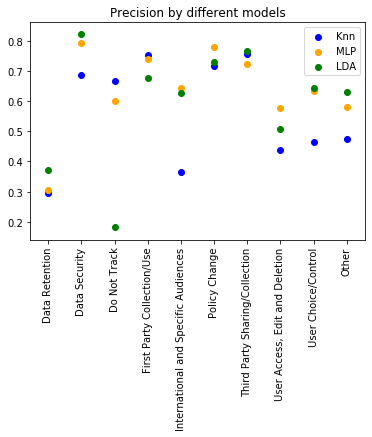

In [359]:
plt.title("Precision by different models")
plt.scatter(range(0,10), precision_knn, color='blue', label= 'Knn')
plt.scatter(range(0,10), precision_mlp, color='orange', label = 'MLP' )
plt.scatter(range(0,10), precision_lda, color='green', label="LDA")

plt.xticks([0,1, 2,3,4,5,6,7,8,9],('Data Retention','Data Security', 'Do Not Track', 'First Party Collection/Use', 'International and Specific Audiences',
            'Policy Change','Third Party Sharing/Collection','User Access, Edit and Deletion','User Choice/Control','Other'), rotation=90)

plt.legend()

plt.show()

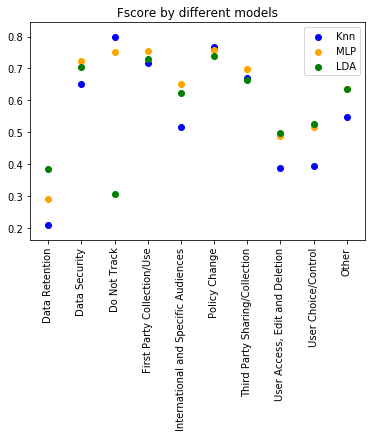

In [363]:
plt.title("Fscore by different models")
plt.scatter(range(0,10), fscore_knn, color='blue', label= 'Knn')
plt.scatter(range(0,10), fscore_mlp, color='orange', label = 'MLP' )
plt.scatter(range(0,10), fscore_lda, color='green', label="LDA")

plt.xticks([0,1, 2,3,4,5,6,7,8,9],('Data Retention','Data Security', 'Do Not Track', 'First Party Collection/Use', 'International and Specific Audiences',
            'Policy Change','Third Party Sharing/Collection','User Access, Edit and Deletion','User Choice/Control','Other'), rotation=90)

plt.legend()

plt.show()